### Importing the standard libraries

In [2]:
#Author : Digbalay Bose
#importing all the standard packages (numpy, torch, torchvision)
import matplotlib.pyplot as plt
import numpy as np

#torch,torchvision, torchvision transforms
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F #useful library for operations like relu 
import torch.optim as optim

### Setting up tensorboard

In [1]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fashion_mnist_experiment_run')

### Helper function for plotting images in a grid 

In [3]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize (inverse operation of normalization transform)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### List of transforms to be applied to the dataset

In [4]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

### Declaring the fashionmnist train, test and validation datasets

In [5]:
# acquiring the fashionmnist datasets
dataset = torchvision.datasets.FashionMNIST('../../../../discussion_pytorch/data',
    download=True,
    train=True,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.FashionMNIST('../../../../discussion_pytorch/data',
    download=True,
    train=False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
## Don't touch the test data 


split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])



### Declaring the train validation and test dataloaders

In [6]:
# dataloaders
#shuffle enabled as True for the train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True)

#shuffle enabled as False for the valid dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False) 

#shuffle enabled as False for the test dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False) 


### Declaring the list of classes in fashionmnist

In [7]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot') #classes for fashion mnist

### Checking the number of training, validation and testing images

In [8]:
#inspecting the length of datasets (test and train datasets)
num_train_samples=len(trainset)
print(num_train_samples)
num_test_samples=len(testset)
print(num_test_samples)
num_val_samples=len(valset)
print(num_val_samples)

48000
10000
12000


### Check batches from dataloader

In [10]:
inputs,labels=next(iter(trainloader)) #generate a single batch from trainloader 
print(len(trainloader)) #number of batches 
48000//64 #no of samples // batch_size

750


750

### Inspect the input images generated from dataloader

In [11]:
print(inputs.size())
#inputs=inputs.numpy() #convert from tensor to numpy array
#plot the images here
#will be later used in tensorboard plot

torch.Size([64, 1, 28, 28])


### Use tensorboard for displaying the images 

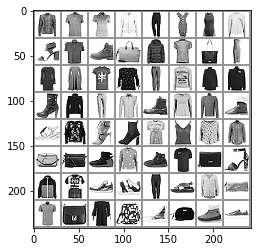

In [12]:
# create grid of images
img_grid = torchvision.utils.make_grid(inputs)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

### Network architecture 

In [15]:
#Declaring the network architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  #declare all layers
        self.linear_1=nn.Linear(784,128) #input_dimensions x output_dimensions
        self.linear_2=nn.Linear(128,10)
    def forward(self,x):
        #x is a single batch (batch_size,28,28,1)
        x=x.squeeze(1)# removing the 1 in input batch (resizing from (batch_size,1,28,28) to (batch_size,28,28))
        x=x.view(-1,28*28) #resizing from (batch_size,28*28) to (batch_size,784)
        x=self.linear_1(x) #passing through linear layer (784*128)
        x=F.relu(x) #passing through relu activation
        x=self.linear_2(x) #passing through output linear layer 
        return(x)

In [16]:
net=Net()

In [17]:
net

Net(
  (linear_1): Linear(in_features=784, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
)

### Adding model to tensorboard

In [18]:
writer.add_graph(net, inputs)
writer.close()

### Device selection

In [21]:
### Device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net=net.to(device)

cpu


### Model layout using torchsummary 

In [20]:
from torchsummary import summary
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### Testing function 

In [24]:
#defining the test/validation loop here 
#eval_model function runs the test/validation on the given data 
def eval_model(model,loader,criterion,device):
    """model: instance of model class 
       loader: test dataloader
       criterion: loss function
       device: CPU/GPU
    """
    model.eval() #needed to run the model in eval mode to freeze all the layers
    correct=0
    total=0
    total_loss=0
    with torch.no_grad():
        total=0
        correct=0
        for idx,(inputs,labels) in enumerate(loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            outputs=F.softmax(outputs,dim=1)
            val_loss=criterion(outputs,labels)
            total_loss=total_loss+val_loss
            preds=torch.max(outputs,dim=1)[1]
            
            correct=correct+(preds==labels).cpu().sum().numpy() 
            total=total+len(labels)
    Accuracy=100*(correct/total)
    fin_loss=total_loss/(len(loader))
    
    return(Accuracy,fin_loss)


### Loss function and optimizer definition

In [25]:
#defining loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Main training loop

In [26]:
num_epochs=5
net=net.to(device)
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
best_val_acc=0

#TRAINING LOOP
for i in np.arange(num_epochs): #outer loop 
    train_loss=0.0
    correct=0
    for idx,(inputs,labels) in enumerate(trainloader): #inner loop for data loader
        #sending inputs and labels to device 
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        #zero out the gradients to avoid any accumulation during backprop
        optimizer.zero_grad()
        
        #forward pass through the network
        outputs = net(inputs) #batch_size x 10
        
        #compute the loss between ground truth labels and outputs
        loss = criterion(outputs, labels)
        
        loss.backward() #computes derivative of loss for every variable (gradients)
        optimizer.step() #optimizer updates based on gradients 
        
        preds=torch.max(outputs,dim=1)[1] # obtaining the predicted class (dimension of outputs is batch_size x number of classes)
        correct=correct+(preds==labels).cpu().sum().numpy() #.cpu() transfers tensors from GPU to CPU
        train_loss=train_loss+loss.item()
        
        
        
        
    train_loss=train_loss/len(trainloader) #computing the total loss for the entire training set
    train_accuracy=100*(correct/len(trainloader.dataset)) #train accuracy for the dataset
    val_accuracy,val_loss=eval_model(net,valloader,criterion,device) #validation accuracy, validation loss for the entire validation set 
    
    writer.add_scalar('training loss',
                            train_loss,i+1)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    net.train(True)
    print('Epoch:%d,Train Loss:%f,Training Accuracy:%f,Validation Accuracy:%f'%(i+1,train_loss,train_accuracy,val_accuracy))
    if(val_accuracy > best_val_acc):
        print('Saving the best model')
        best_val_acc=val_accuracy
        torch.save({
            'epoch': i+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss}, 'fashionmnist_best_model.pth') #saving all the required information in .pth file (required for restarting models later)
        

writer.close()


Epoch:1,Train Loss:0.391506,Training Accuracy:85.727083,Validation Accuracy:86.575000
Saving the best model
Epoch:2,Train Loss:0.351995,Training Accuracy:87.066667,Validation Accuracy:86.375000
Epoch:3,Train Loss:0.324589,Training Accuracy:87.991667,Validation Accuracy:87.641667
Saving the best model
Epoch:4,Train Loss:0.305514,Training Accuracy:88.675000,Validation Accuracy:87.208333
Epoch:5,Train Loss:0.290079,Training Accuracy:89.168750,Validation Accuracy:88.216667
Saving the best model


### Plot the training and test performance

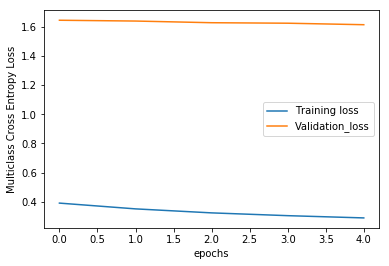

In [27]:
plt.figure()
plt.plot(np.arange(num_epochs), train_loss_list, label='Training loss')
plt.plot(np.arange(num_epochs), val_loss_list, label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.legend()
plt.show()
#plt.savefig('learning_loss_fapi.png', dpi=256)

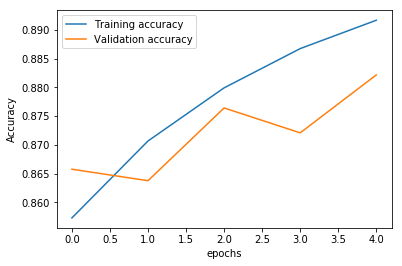

In [28]:
plt.figure()
plt.plot(np.arange(num_epochs), np.array(train_acc_list)/100, label='Training accuracy')
plt.plot(np.arange(num_epochs), np.array(val_acc_list)/100, label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Saving trained models 

In [29]:
#saving the entire model 
torch.save(net,'fashionmnist_model.pth')

/Users/digbalaybose/miniconda3/lib/python3.5/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Loading saved models 

In [30]:
### loading the saved entire model 
fashionmnist_model_total=torch.load('fashionmnist_model.pth')

### loading the saved best model with state dict 

fashionmnist_best_model=Net() #declare the model class 
checkpoint=torch.load('fashionmnist_best_model.pth')
fashionmnist_best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Running inference with the saved models 

In [31]:
##inference with the saved entire model 
fashionmnist_model_total.eval()
test_accuracy_total,test_loss_total=eval_model(fashionmnist_model_total,testloader,criterion,device)
print('Test accuracy using the entire saved model:%f' %(test_accuracy_total))
print('Test loss using the entire saved model:%f' %(test_loss_total))

##inference with the best model loaded from state dict
fashionmnist_best_model.eval()
test_accuracy_best,test_loss_best=eval_model(fashionmnist_best_model,testloader,criterion,device)
print('Test accuracy using the best saved model:%f' %(test_accuracy_best))
print('Test loss using the best saved model:%f' %(test_loss_best))

Test accuracy using the entire saved model:87.180000
Test loss using the entire saved model:1.621104
Test accuracy using the best saved model:87.180000
Test loss using the best saved model:1.621104
